<a href="https://colab.research.google.com/github/Lucas-Petrus/DS-Unit-2-Kaggle-Challenge/blob/master/LucasPetrus_July16_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)


X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test


pipeline = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
)


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8015043877977435


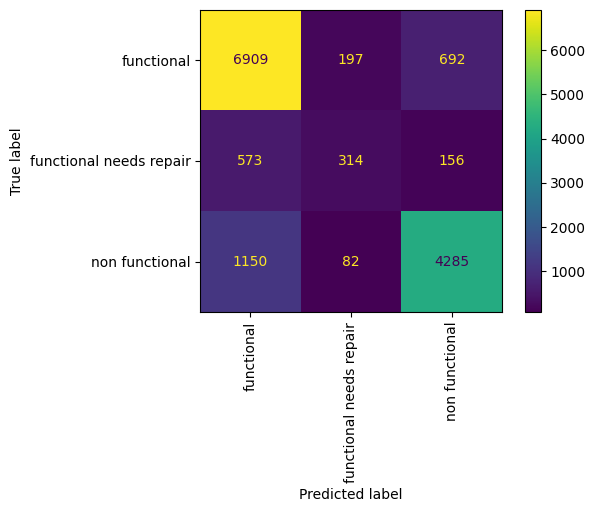

In [5]:
from sklearn.metrics import plot_confusion_matrix, classification_report

plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [20]:
pipeline = make_pipeline(
  OrdinalEncoder(drop_invariant=True),
  SimpleImputer(strategy='most_frequent'),
  StandardScaler(with_mean=False),
  RandomForestClassifier(
      criterion = 'entropy',
      max_depth=19,
      min_samples_split=7,
      max_features=9,
      n_estimators= 37,
      n_jobs=-1)
)

param_distributions = {
    #'randomforestclassifier__criterion': ('gini','entropy'),
    #'randomforestclassifier__max_depth' : (19,25,31),
    #'randomforestclassifier__max_features': (7,8,9),
    #'randomforestclassifier__min_samples_split': (6,7,8,9)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    cv=14,
    scoring='accuracy',
    verbose = 20,
    return_train_score=True,
    n_jobs=-1,
)

search.fit(X_train, y_train)
print('Cross-validation Best Score', search.best_score_)
print('Best Estimator', search.best_params_)
print('Best Model', search.best_estimator_)
print('training accuracy:', search.score(X_train, y_train))
print('validation accuracy:', search.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 14 folds for each of 1 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  1.7min remaining:   17.3s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  2.0min finished


Cross-validation Best Score 0.803250544233471
Best Estimator {}
Best Model Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['date_recorded', 'funder', 'installer',
                                      'wpt_name', 'basin', 'subvillage',
                                      'region', 'lga', 'ward', 'public_meeting',
                                      'recorded_by', 'scheme_management',
                                      'scheme_name', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_t...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                              

In [21]:
y_pred = search.predict(X_test)

num = 1

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission['status_group'] = submission['status_group']
submission.to_csv(f'submission-{num}.csv', index=False)
submission['status_group'].value_counts()

num += 1